In [2]:
# imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
# Imposta il device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Percorso del dataset (immagini preprocessate con data augmentation)
dataset_dir = "./train_balanced"

# Trasformazioni: Normalizzazione e Preprocessing finale
transform = transforms.Compose([
    #transforms.Grayscale(),
    transforms.ToTensor(),  # Conversione a tensore
])

In [4]:
# Creazione del Dataset
dataset = ImageFolder(root=dataset_dir, transform=transform)

# Suddivisione Train/Test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle= False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Controllo rapido
print(f"Numero di immagini nel train set: {len(train_dataset)}")
print(f"Numero di immagini nel test set: {len(test_dataset)}")
print(f"Classi disponibili: {dataset.classes}")

Numero di immagini nel train set: 1476
Numero di immagini nel test set: 369
Classi disponibili: ['0', '1', '2', '3', '4']


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, dropout_rate=0.25):
        super(SimpleCNN, self).__init__()

        # Convolutional Section
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 48x48

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 24x24

            nn.Conv2d(16,32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Dropout(dropout_rate),  # Dropout for regularization
        )

        # Fully Connected Section
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32, 5),  # Fully connected
        )

    def forward(self, x):
        x = self.network(x)
        x = self.fc(x)
        return x
    
model = SimpleCNN().to(device)

In [6]:
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5) 

# Loop di training
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    correct = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #scheduler.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
    
    accuracy = 100 * correct / len(loader.dataset)
    return running_loss / len(loader), accuracy

In [7]:
def evaluate(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    return y_true, y_pred

In [8]:
'''
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    print(f"Epoch {epoch+1}/{num_epochs}: Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
'''

'''
test_set = ImageFolder(root='./test', transform=transform)
test_set_loader = DataLoader(test_set, batch_size=32, shuffle=False)

y_true, y_pred = evaluate(model, test_set_loader)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.dataset.classes))
'''

Epoch 1/10: Loss: 1.6002, Accuracy: 23.92%
Epoch 2/10: Loss: 1.5606, Accuracy: 32.32%
Epoch 3/10: Loss: 1.5181, Accuracy: 35.37%
Epoch 4/10: Loss: 1.4785, Accuracy: 38.01%
Epoch 5/10: Loss: 1.4498, Accuracy: 39.30%
Epoch 6/10: Loss: 1.4331, Accuracy: 39.36%
Epoch 7/10: Loss: 1.4206, Accuracy: 39.30%
Epoch 8/10: Loss: 1.4123, Accuracy: 39.63%
Epoch 9/10: Loss: 1.4009, Accuracy: 40.11%
Epoch 10/10: Loss: 1.3950, Accuracy: 39.50%


### Parameter Search

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [11]:
test_set = ImageFolder(root='./test', transform=transform)
test_set_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [9]:
# Parametri di ricerca
epoch_list = [5, 10, 15, 20]
learning_rate_list = [0.01, 0.001, 0.0001]
dropout_list = [0, 0.25, 0.5]
weight_decay_list = [0.01, 0.001, 0.0001]

In [13]:
results = []
# Inizia la grid search
for dropout_rate in dropout_list:
    for lr in learning_rate_list:
        for weight_decay in weight_decay_list:
            for epochs in epoch_list:
                print(f"Training with dropout {dropout_rate}, lr {lr}, wd {weight_decay}, epochs {epochs}...")
                
                # Definisci il modello
                model = SimpleCNN(dropout_rate=dropout_rate).to(device)
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                criterion = nn.CrossEntropyLoss()

                # Training loop
                model.train()
                all_labels = []  # Per tenere traccia di tutte le etichette
                all_predictions = []  # Per tenere traccia di tutte le predizioni

                for epoch in range(epochs):
                    epoch_loss = 0
                    correct = 0
                    total = 0
                    for images, labels in train_loader:
                        images, labels = images.to(device), labels.to(device)

                        optimizer.zero_grad()
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        _, predicted = outputs.max(1)
                        total += labels.size(0)
                        correct += predicted.eq(labels).sum().item()
                        
                        # Aggiungi le etichette e le predizioni alla lista
                        all_labels.extend(labels.cpu().numpy())
                        all_predictions.extend(predicted.cpu().numpy())
                    
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {100. * correct / total:.2f}%")

                # Ora valutiamo il modello sul test set
                model.eval()
                all_labels = []  # Per tenere traccia di tutte le etichette
                all_predictions = []  # Per tenere traccia di tutte le predizioni

                with torch.no_grad():  # Disabilita il calcolo del gradiente per la valutazione
                    for images, labels in test_loader:
                        images, labels = images.to(device), labels.to(device)

                        outputs = model(images)
                        _, predicted = outputs.max(1)

                        all_labels.extend(labels.cpu().numpy())
                        all_predictions.extend(predicted.cpu().numpy())

                # Calcola precision, recall, f1 score sul test set
                precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
                recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
                f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

                # Registra risultati finali
                results.append({
                    "dropout_rate": dropout_rate,
                    "learning_rate": lr,
                    "weight_decay": weight_decay,
                    "epochs": epochs,
                    "final_accuracy": 100. * correct / total,
                    "final_loss": epoch_loss,
                    "precision": precision,
                    "recall": recall,
                    "f1_score": f1
                })

# Mostra i risultati
print("Results:")
for result in results:
    print(result)

Training with dropout 0, lr 0.01, wd 0.01, epochs 5...
Epoch 1/5, Loss: 72.2381, Accuracy: 29.81%
Epoch 2/5, Loss: 69.3791, Accuracy: 35.03%
Epoch 3/5, Loss: 68.7403, Accuracy: 37.26%
Epoch 4/5, Loss: 68.7069, Accuracy: 36.31%
Epoch 5/5, Loss: 68.2361, Accuracy: 37.33%
Training with dropout 0, lr 0.01, wd 0.01, epochs 10...
Epoch 1/10, Loss: 72.2639, Accuracy: 29.34%
Epoch 2/10, Loss: 69.2766, Accuracy: 35.77%
Epoch 3/10, Loss: 69.3834, Accuracy: 34.15%
Epoch 4/10, Loss: 68.5834, Accuracy: 36.72%
Epoch 5/10, Loss: 68.4552, Accuracy: 36.86%
Epoch 6/10, Loss: 68.2613, Accuracy: 37.94%
Epoch 7/10, Loss: 68.2309, Accuracy: 37.87%
Epoch 8/10, Loss: 68.1847, Accuracy: 38.69%
Epoch 9/10, Loss: 68.0126, Accuracy: 37.67%
Epoch 10/10, Loss: 67.9864, Accuracy: 37.53%
Training with dropout 0, lr 0.01, wd 0.01, epochs 15...
Epoch 1/15, Loss: 73.9374, Accuracy: 27.71%
Epoch 2/15, Loss: 70.4236, Accuracy: 34.69%
Epoch 3/15, Loss: 69.0381, Accuracy: 36.38%
Epoch 4/15, Loss: 68.8516, Accuracy: 36.11%
E

Find best parameters (tradeoff between Accuracy and F1-score)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Converte la lista dei risultati in un DataFrame pandas
results_df = pd.DataFrame(results)

In [28]:
# Calcolo del punteggio di trade-off
results_df["tradeoff_score"] = (results_df["final_accuracy"] + results_df["f1_score"]) / 2

# Trovare la combinazione con il punteggio di trade-off massimo
best_combination = results_df.sort_values(by="tradeoff_score", ascending=False).iloc[0]

print("Combinazione migliore per Accuracy e F1 Score:")
print(best_combination)

# Visualizzare le prime 5 combinazioni
top_5_combinations = results_df.sort_values(by="tradeoff_score", ascending=False).head(5)
print("\nTop 5 combinazioni per Accuracy e F1 Score:")
print(top_5_combinations)

Combinazione migliore per Accuracy e F1 Score:
dropout_rate       0.250000
learning_rate      0.010000
weight_decay       0.000100
epochs            20.000000
final_accuracy    46.951220
final_loss        60.059697
precision          0.258665
recall             0.292683
f1_score           0.208384
tradeoff_score    23.579802
Name: 47, dtype: float64

Top 5 combinazioni per Accuracy e F1 Score:
    dropout_rate  learning_rate  weight_decay  epochs  final_accuracy  \
47          0.25          0.010        0.0001      20       46.951220   
11          0.00          0.010        0.0001      20       46.747967   
91          0.50          0.001        0.0010      20       46.612466   
95          0.50          0.001        0.0001      20       46.544715   
83          0.50          0.010        0.0001      20       46.138211   

    final_loss  precision    recall  f1_score  tradeoff_score  
47   60.059697   0.258665  0.292683  0.208384       23.579802  
11   60.948901   0.454855  0.365854 

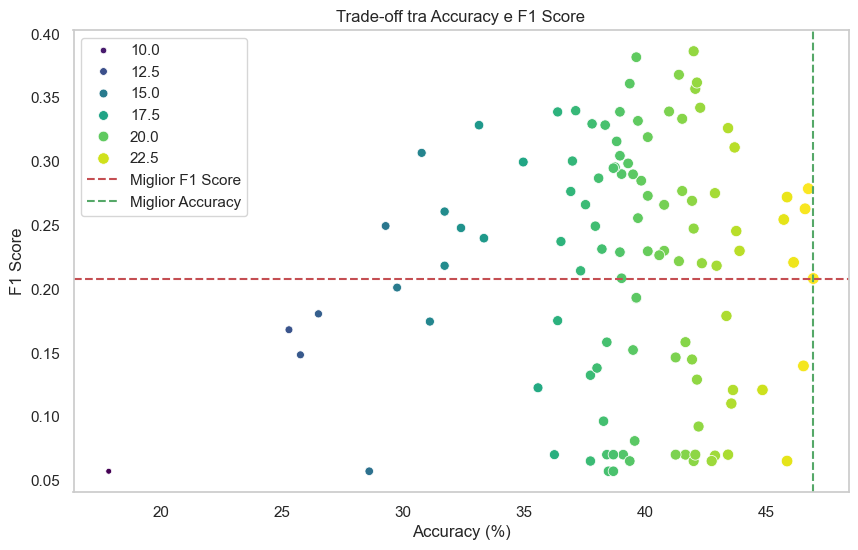

In [29]:
# Visualizzare graficamente il trade-off tra Accuracy e F1 Score
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results_df, 
    x="final_accuracy", 
    y="f1_score", 
    hue="tradeoff_score", 
    size="tradeoff_score", 
    palette="viridis", 
    legend="brief"
)
plt.title("Trade-off tra Accuracy e F1 Score")
plt.xlabel("Accuracy (%)")
plt.ylabel("F1 Score")
plt.axhline(y=best_combination["f1_score"], color="r", linestyle="--", label="Miglior F1 Score")
plt.axvline(x=best_combination["final_accuracy"], color="g", linestyle="--", label="Miglior Accuracy")
plt.legend()
plt.grid()
plt.show()

### Plots

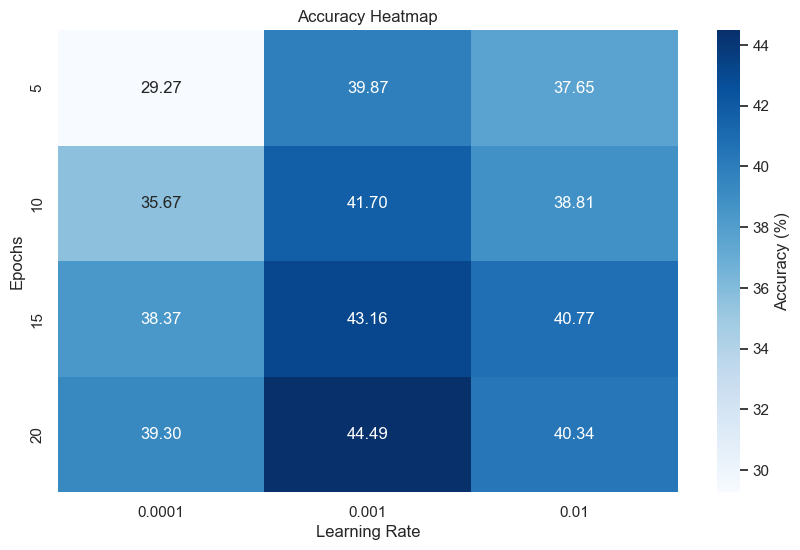

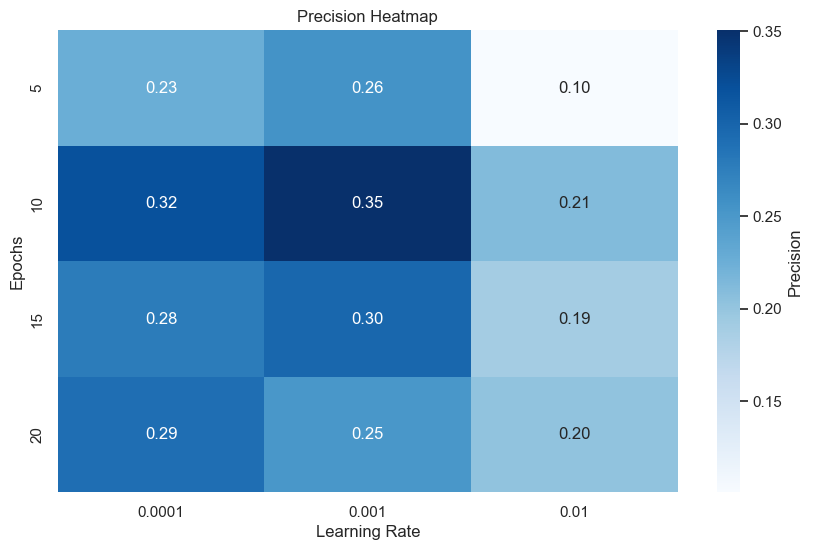

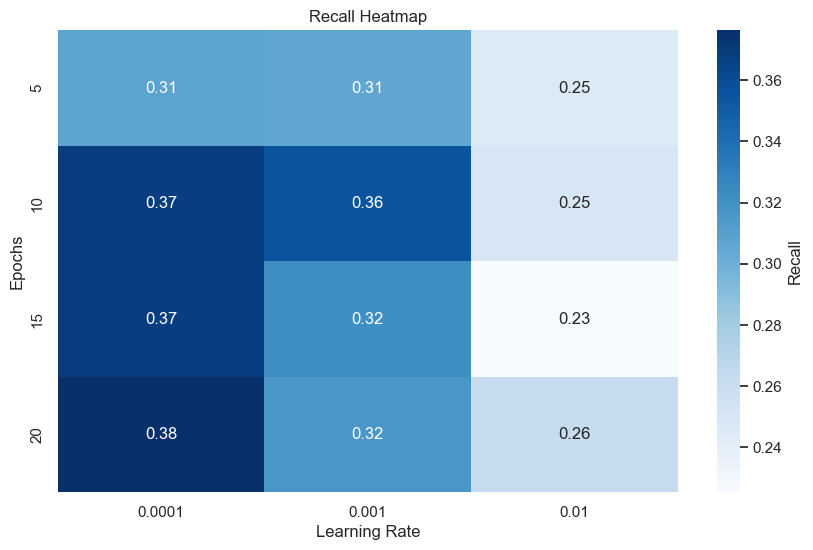

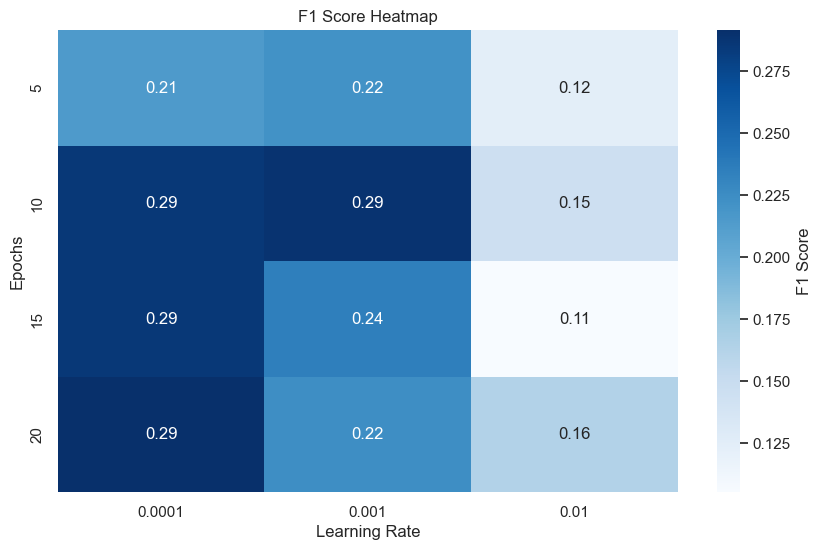

In [16]:
# Impostazione di seaborn per grafici più belli
sns.set(style="whitegrid")

# 1. Plot di Accuracy
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='epochs', columns='learning_rate', values='final_accuracy'),
            annot=True, fmt=".2f", cmap='Blues', cbar_kws={'label': 'Accuracy (%)'})
plt.title("Accuracy Heatmap")
plt.xlabel("Learning Rate")
plt.ylabel("Epochs")
plt.show()

# 2. Plot di Precision
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='epochs', columns='learning_rate', values='precision'),
            annot=True, fmt=".2f", cmap='Blues', cbar_kws={'label': 'Precision'})
plt.title("Precision Heatmap")
plt.xlabel("Learning Rate")
plt.ylabel("Epochs")
plt.show()

# 3. Plot di Recall
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='epochs', columns='learning_rate', values='recall'),
            annot=True, fmt=".2f", cmap='Blues', cbar_kws={'label': 'Recall'})
plt.title("Recall Heatmap")
plt.xlabel("Learning Rate")
plt.ylabel("Epochs")
plt.show()

# 4. Plot di F1 Score
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='epochs', columns='learning_rate', values='f1_score'),
            annot=True, fmt=".2f", cmap='Blues', cbar_kws={'label': 'F1 Score'})
plt.title("F1 Score Heatmap")
plt.xlabel("Learning Rate")
plt.ylabel("Epochs")
plt.show()


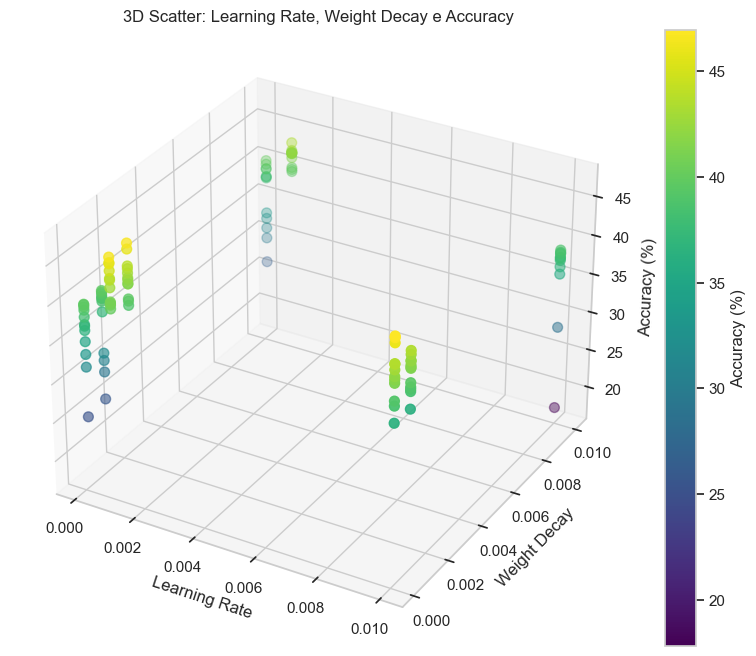

In [20]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    results_df["learning_rate"], 
    results_df["weight_decay"], 
    results_df["final_accuracy"], 
    c=results_df["final_accuracy"], cmap="viridis", s=50
)

ax.set_title("3D Scatter: Learning Rate, Weight Decay e Accuracy")
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Weight Decay")
ax.set_zlabel("Accuracy (%)")
fig.colorbar(sc, label="Accuracy (%)")
plt.show()


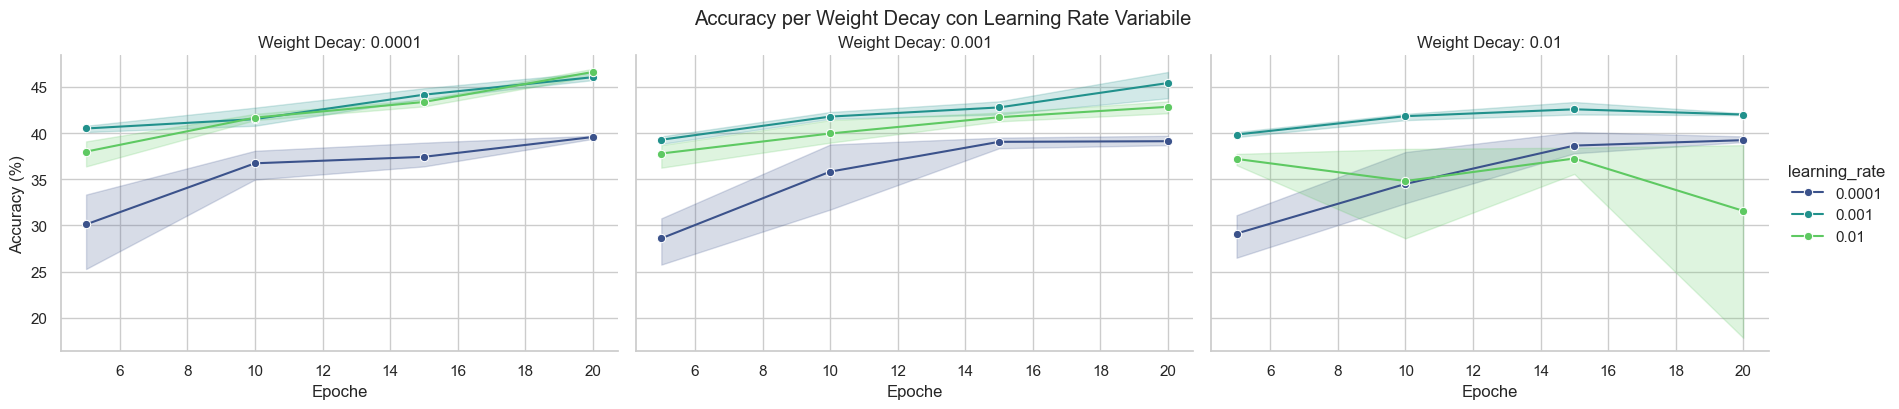

In [21]:
g = sns.FacetGrid(results_df, col="weight_decay", hue="learning_rate", height=4, aspect=1.5, palette="viridis")
g.map(sns.lineplot, "epochs", "final_accuracy", marker="o").add_legend()
g.set_titles("Weight Decay: {col_name}")
g.set_axis_labels("Epoche", "Accuracy (%)")
g.fig.suptitle("Accuracy per Weight Decay con Learning Rate Variabile", y=1.02)
plt.show()


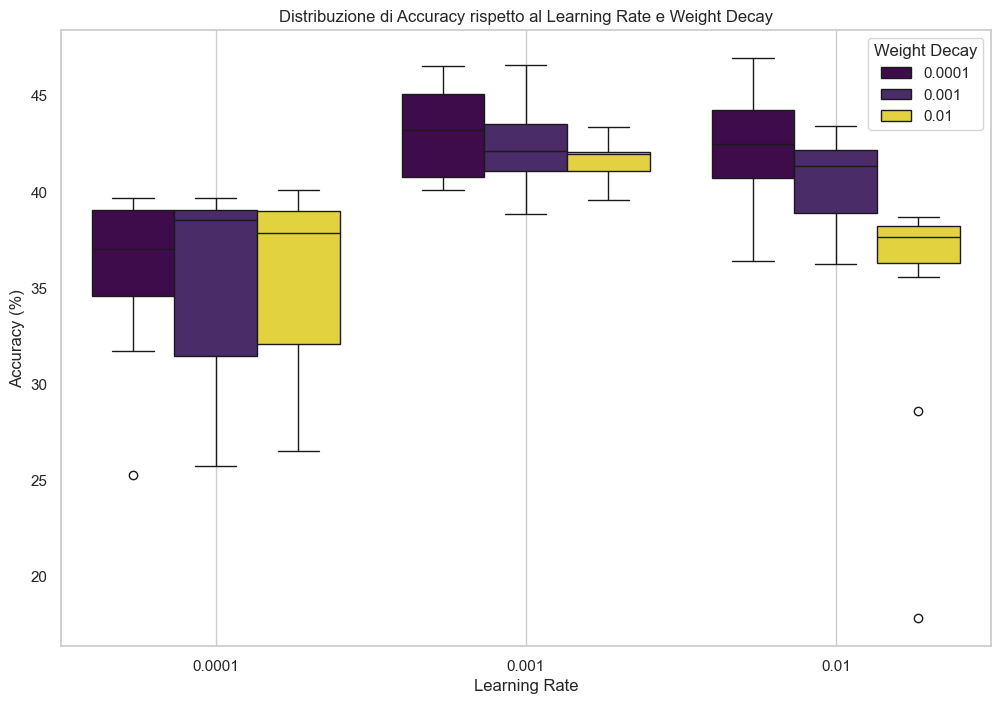

In [22]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=results_df, x="learning_rate", y="final_accuracy", hue="weight_decay", palette="viridis")
plt.title("Distribuzione di Accuracy rispetto al Learning Rate e Weight Decay")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy (%)")
plt.legend(title="Weight Decay")
plt.grid()
plt.show()


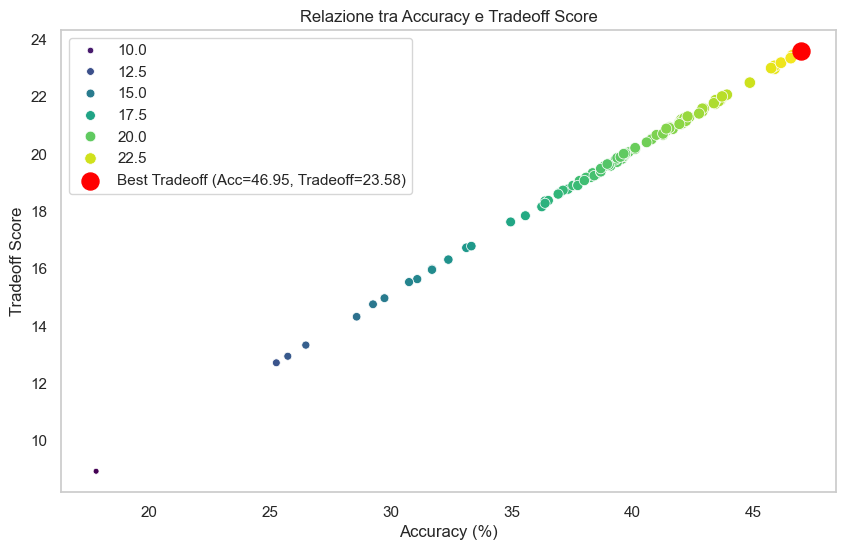

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot per visualizzare Accuracy vs Tradeoff Score
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results_df, 
    x="final_accuracy", 
    y="tradeoff_score", 
    hue="tradeoff_score", 
    palette="viridis", 
    size="tradeoff_score", 
    legend="brief"
)

# Miglior combinazione
best_tradeoff = results_df.loc[results_df["tradeoff_score"].idxmax()]

# Evidenziamo il punto migliore
plt.scatter(
    best_tradeoff["final_accuracy"], 
    best_tradeoff["tradeoff_score"], 
    color="red", 
    s=150, 
    label=f"Best Tradeoff (Acc={best_tradeoff['final_accuracy']:.2f}, Tradeoff={best_tradeoff['tradeoff_score']:.2f})"
)

plt.title("Relazione tra Accuracy e Tradeoff Score")
plt.xlabel("Accuracy (%)")
plt.ylabel("Tradeoff Score")
plt.legend()
plt.grid()
plt.show()


In [1]:
# Accuracy vs Dropout Rate
sns.barplot(x="dropout_rate", y="final_accuracy", data=results_df)
plt.title("Effect of Dropout Rate on Accuracy")
plt.xlabel("Dropout Rate")
plt.ylabel("Final Accuracy (%)")
plt.show()

NameError: name 'sns' is not defined

In [ ]:

sns.barplot(x="Dataset Configuration", y="Score", hue="Metric", data=df[df["Model"] == "Dual CNN"])
plt.title("Dual CNN: Accuracy and F1-Score across Datasets")
plt.ylabel("Score (%)")
plt.xlabel("Dataset Configuration")
plt.legend(title="Metric")
plt.ylim(60, 90)
plt.grid()
plt.show()